# III.A: Validation With External Software

In [1]:
import os
import numpy as np
from pytomography.algorithms import BSREM, OSEM
from pytomography.io.SPECT import simind
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projectors import SPECTSystemMatrix
from torchmetrics.image import StructuralSimilarityIndexMeasure
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from scipy.ndimage import zoom
import torch

Change this to where data is saved

In [2]:
datapath = '/disk1/pytomography_paper_data/'

Open ground truth image

In [3]:
GT = np.fromfile(os.path.join(datapath, 'simind', 'body1_Lu177_T2.bin'), dtype=np.float32)
GT = GT.reshape((751,512,512))
GT = np.transpose(GT, (2,1,0))
GT = np.pad(GT, ((0,0),(0,0),(8,8)))
GT = zoom(GT, (128/512, 128/512, 384/767), order=0, mode='nearest')
calib = 0.21089022221130554 #calibration constant from SIMIND output file

In [4]:
CT = simind.get_attenuation_map(os.path.join(datapath, 'simind', 'body1.hct'))

Ti

1. Reconstruct using PyTomography

In [5]:
headerfile = os.path.join(datapath, 'simind', 'body1t2ew6_tot_w2.hdr')
object_meta, proj_meta = simind.get_metadata(headerfile)
photopeak = simind.get_projections(headerfile)
CT = simind.get_attenuation_map(os.path.join(datapath, 'simind', 'body1.hct'))
att_transform = SPECTAttenuationTransform(CT)
psf_meta = simind.get_psfmeta_from_header(headerfile)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SPECTSystemMatrix(
            obj2obj_transforms = [att_transform,psf_transform],
            proj2proj_transforms = [],
            object_meta = object_meta,
            proj_meta = proj_meta,
            n_parallel=15)
reconstruction_algorithm = OSEM(
            projections = photopeak,
            system_matrix = system_matrix)
reconstructed_object = reconstruction_algorithm(n_iters=2, n_subsets=8)
reconstructed_object = reconstructed_object[0].cpu().numpy() #* calib

2. Open reconstructed STIR file (obtained using `OSMAPOSL recon.par` in `test_files` folder)

In [6]:
reconstructed_object_stir = np.fromfile(os.path.join(datapath, 'simind', 'OSEM_16.v'), dtype=np.float32)
reconstructed_object_stir = np.transpose(reconstructed_object_stir.reshape(384,128,128)[::-1,::-1,::-1], (2,1,0)) #* calib

Slices and profile indices

In [7]:
s = 64
l1 = 167
l2 = 250
l3 = 315
#delta = reconstructed_object - reconstructed_object_stir

Plotting functions

In [16]:
def plot_differences(ax,l, uppery=None, lowery=None):
    #plt.plot(GT[:,64,l], color='k', lw=2)
    stir = reconstructed_object_stir[:,64,l]
    pytomo = reconstructed_object[:,64,l]
    diff = stir - pytomo
    ax.plot(np.arange(128)*0.3,stir, marker='', ls='-', lw=1.5, color='r', label='STIR')
    ax.plot(np.arange(128)*0.3,pytomo, marker='', ls='--', lw=2.5, color='blue', label='PyTomography')
    ax.plot(np.arange(128)*0.3,diff, marker='', ls='-', lw=2.5, color='k', label='Difference', zorder=-10000)
    #ax.plot(np.arange(128)*0.3,np.abs(reconstructed_object[:,s,l]-reconstructed_object_stir[:,s,l])*100, ls='dotted', color='dimgrey', label='Difference (x100)')
    #plt.plot(delta[:,64,l])
    ax.grid()
    if uppery: ax.set_ylim(top=uppery)
    if lowery: ax.set_ylim(bottom=lowery)
    
def plot_object(ob, ax, add_text=False, mode='color'):
    if mode=='color':
        tcol = 'white'
        cmap = 'nipy_spectral'
        vmax = 5
    elif mode=='bw':
        tcol = 'red'
        cmap = 'Greys'
        vmax = 0.5
    im = ax.pcolormesh(ob[:,64].T, cmap=cmap, vmax=vmax)
    ax.axhline(l1, ls='--', color=tcol, lw=0.8)
    ax.axhline(l2, ls='--', color=tcol, lw=0.8)
    ax.axhline(l3, ls='--', color=tcol, lw=0.8)
    #ax.axis('off')
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    if add_text:
        ax.text(5, l3+7, '1', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l2+7, '2', ha='center', va='center', color=tcol, size=13)
        ax.text(5, l1+7, '3', ha='center', va='center', color=tcol, size=13)
    return im

Plot

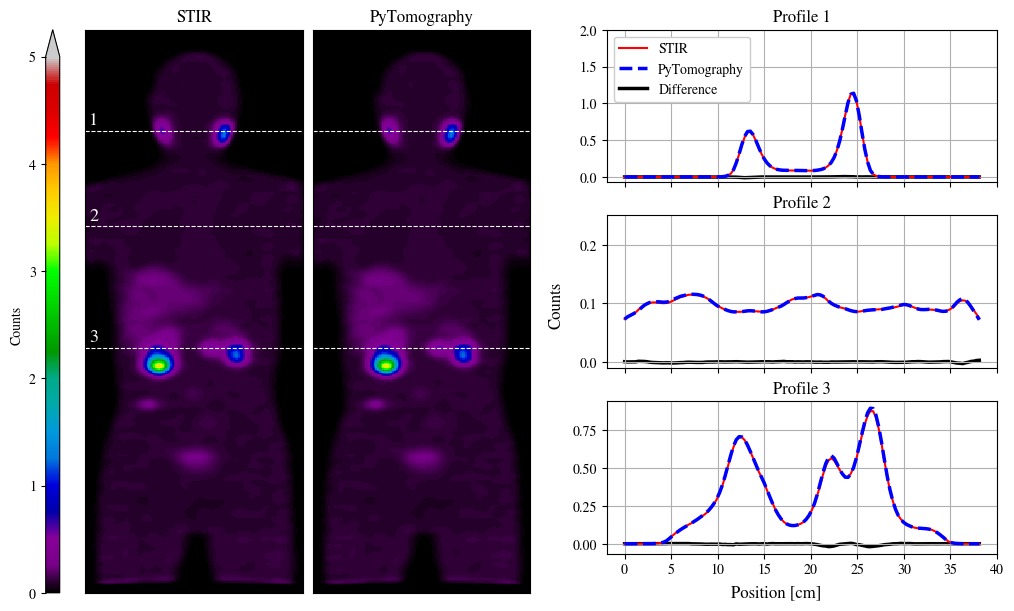

In [20]:
mode = 'color'
fig = plt.figure(constrained_layout=True, figsize=(10,6))
(subfig_l, subfig_r) = fig.subfigures(nrows=1, ncols=2, width_ratios=(0.85,0.75))
axes_l = subfig_l.subplots(nrows=1, ncols=2)
axes_l[0].set_title('STIR')
axes_l[1].set_title('PyTomography')
im = plot_object(reconstructed_object_stir, axes_l[0], add_text=True, mode=mode)
im = plot_object(reconstructed_object, axes_l[1], mode=mode)
subfig_l.colorbar(im, ax=axes_l, location='left', label='Counts', extend='max', aspect=40)
axes_r = subfig_r.subplots(nrows=3, ncols=1, sharex=True)
plot_differences(axes_r[0],l3)
axes_r[0].set_title('Profile 1')
axes_r[0].set_ylim(top=2)
axes_r[0].legend(loc='upper left', facecolor='white', framealpha=1, frameon=True, fontsize=10)
plot_differences(axes_r[1],l2, uppery=0.25, lowery=-0.01)
axes_r[1].set_title('Profile 2')
plot_differences(axes_r[2],l1)
axes_r[2].set_title('Profile 3')
subfig_r.supxlabel('Position [cm]')
subfig_r.supylabel('Counts')
plt.savefig('images/figure7.jpg', dpi=300)

Statistics computed in paper:

In [10]:
mask = reconstructed_object>0.05

* Maximum error

In [11]:
np.max((reconstructed_object[mask] - reconstructed_object_stir[mask]) / reconstructed_object_stir[mask] * 100)

23.596972

* RMSE

In [12]:
np.sqrt(((reconstructed_object - reconstructed_object_stir) ** 2).mean())

0.0016470836

* SSIM

In [13]:
r1 = torch.tensor(reconstructed_object).unsqueeze(0).unsqueeze(0)
r2 = torch.tensor(reconstructed_object_stir).unsqueeze(0).unsqueeze(0)
ssim = StructuralSimilarityIndexMeasure()
ssim(r1,r2).item()

ValueError: At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 